In [1]:
!nvidia-smi

Tue May 11 23:24:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.89       Driver Version: 465.89       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 45%   35C    P0    N/A /  75W |    706MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Импортирование библиотек

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import random as rn
import sys
import os
import PIL
from PIL import ImageOps, ImageFilter
from tqdm import tqdm
from datetime import datetime
import cv2

print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Reproducibility

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

# Основные настройки

In [5]:
path_train = 'B:/SKILL_FACTORY/chest_xray/train/'
path_train_norm = 'B:/SKILL_FACTORY/chest_xray/train/NORMAL/'
path_train_pn = 'B:/SKILL_FACTORY/chest_xray/train/PNEUMONIA/'

path_test = 'B:/SKILL_FACTORY/chest_xray/test/'
path_test_norm = 'B:/SKILL_FACTORY/chest_xray/test/NORMAL/'
path_test_pn = 'B:/SKILL_FACTORY/chest_xray/test/PNEUMONIA/'

path_val = 'B:/SKILL_FACTORY/chest_xray/val/'
path_val_norm = 'B:/SKILL_FACTORY/chest_xray/val/NORMAL/'
path_val_pn = 'B:/SKILL_FACTORY/chest_xray/val/PNEUMONIA/'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

IMG_SIZE             = 256 # какого размера подаем изображения в сеть
IMG = IMG_SIZE * IMG_SIZE
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU

In [6]:
checkpoint_path = './logs/model/capsule'
checkpoint_temp_path = './models_temp/capsule'

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = './logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

scalar_logdir = './logs/scalars/%s' % stamp
file_writer = tf.summary.create_file_writer(scalar_logdir + "/metrics")

# EDA + Подготовка данных

In [7]:
sum_train = len(os.listdir(path_train_norm)) + len(os.listdir(path_train_pn))
sum_test = len(os.listdir(path_test_norm)) + len(os.listdir(path_test_pn))
sum_val = len(os.listdir(path_val_norm)) + len(os.listdir(path_val_pn))

print(f'( {len(os.listdir(path_train_norm))} , {round(len(os.listdir(path_train_norm))/sum_train,2)} ) || ( {len(os.listdir(path_train_pn))} , {round(len(os.listdir(path_train_pn))/sum_train,2)} )  {sum_train}')
print(f'( {len(os.listdir(path_test_norm))} , {round(len(os.listdir(path_test_norm))/sum_test,2)} ) || ( {len(os.listdir(path_test_pn))} , {round(len(os.listdir(path_test_pn))/sum_test,2)} )  {sum_test}')
print(f'( {len(os.listdir(path_val_norm))} , {round(len(os.listdir(path_val_norm))/sum_val,2)} ) || ( {len(os.listdir(path_test_norm))} , {round(len(os.listdir(path_val_pn))/sum_val,2)} )   {sum_val}')

( 1341 , 0.26 ) || ( 3875 , 0.74 )  5216
( 234 , 0.38 ) || ( 390 , 0.62 )  624
( 8 , 0.5 ) || ( 234 , 0.5 )   16


In [8]:
def print_all_classes():
    
    
    '''Вывод 1й картинки каждого класса машин'''

    
    cols = 5
    rows = 2
    fig = plt.figure(figsize=(4 * cols - 1, 4 * rows - 1))

    count = 0
    for i in range(cols):
        for j in range(rows):
            if count <5:
                image = PIL.Image.open(
                    path_train+'NORMAL/'+os.listdir(path_train+'NORMAL/')[count],
                    formats=['JPEG'])
            else:
                image = PIL.Image.open(
                    path_train+'PNEUMONIA/'+os.listdir(path_train+'PNEUMONIA/')[count],
                    formats=['JPEG'])
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(image, cmap='gray')
            if count <5:
                ax.set_title(f'Category: NORMAL')
            else:
                ax.set_title(f'Category: PNEUMONIA')
            count += 1

    plt.show()

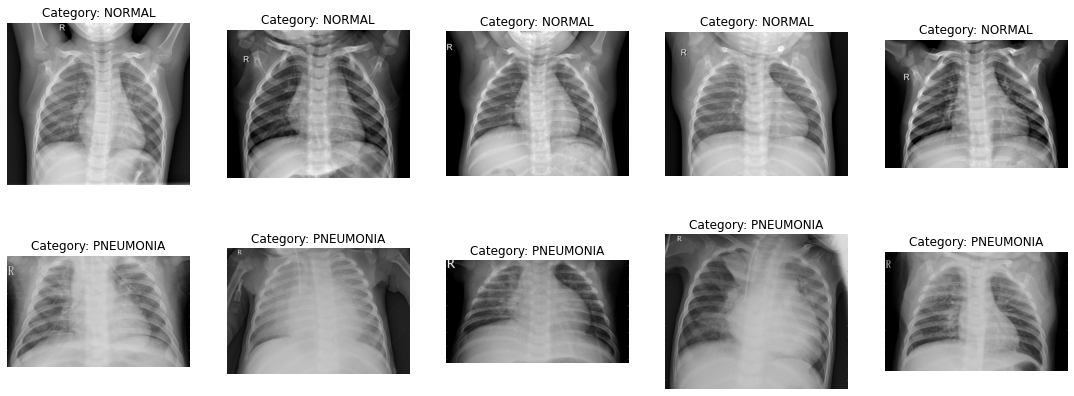

In [9]:
print_all_classes()

In [10]:
norm_tr = len(os.listdir(path_train_norm))
pneum_tr = len(os.listdir(path_train_pn))

norm_t = len(os.listdir(path_test_norm))
pneum_t = len(os.listdir(path_test_pn))

In [11]:
X_train = []
y_train = []
X_test = []
y_test = []

# train
#1341
for i in range(1341):
    image = PIL.Image.open(path_train+'NORMAL/'+os.listdir(path_train+'NORMAL/')[i],
                      formats=['JPEG'])
    image = image.resize((IMG_SIZE,IMG_SIZE))
    if len(np.array(image.getdata()).shape) > 1:
        image = image.convert('L')
    image = np.array(image.getdata()).reshape((IMG_SIZE,IMG_SIZE)) / 255.
    X_train.append(image)
    y_train.append(0)
    
for i in range(1341):
    image = PIL.Image.open(path_train+'PNEUMONIA/'+os.listdir(path_train+'PNEUMONIA/')[i],
                      formats=['JPEG'])
    image = image.resize((IMG_SIZE,IMG_SIZE))
    if len(np.array(image.getdata()).shape) > 1:
        image = image.convert('L')
    image = np.array(image.getdata()).reshape((IMG_SIZE,IMG_SIZE)) / 255.
    X_train.append(image)
    y_train.append(1)

# test
#234
for i in range(234):
    image = PIL.Image.open(path_test+'NORMAL/'+os.listdir(path_test+'NORMAL/')[i],
                      formats=['JPEG'])
    image = image.resize((IMG_SIZE,IMG_SIZE))
    if len(np.array(image.getdata()).shape) > 1:
        image = image.convert('L')
    image = np.array(image.getdata()).reshape((IMG_SIZE,IMG_SIZE)) / 255.
    X_test.append(image)
    y_test.append(0)
    
for i in range(234):
    image = PIL.Image.open(path_test+'PNEUMONIA/'+os.listdir(path_test+'PNEUMONIA/')[i],
                      formats=['JPEG'])
    
    image = image.resize((IMG_SIZE,IMG_SIZE))
    if len(np.array(image.getdata()).shape) > 1:
        image = image.convert('L')
    image = np.array(image.getdata()).reshape((IMG_SIZE,IMG_SIZE)) / 255.
    X_test.append(image)
    y_test.append(1)
    
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2682, 256, 256)
(2682,)
(468, 256, 256)
(468,)


In [13]:
# X_train = X_train / 255.0
X_train = tf.cast(X_train, dtype=tf.float32)
X_train = tf.expand_dims(X_train, axis=-1)

# X_test = X_test / 255.0
X_test = tf.cast(X_test, dtype=tf.float32)
X_test = tf.expand_dims(X_test, axis=-1)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2682, 256, 256, 1)
(2682,)
(468, 256, 256, 1)
(468,)


In [15]:
testing_dataset_size = X_test.shape[0]
training_dataset_size = X_train.shape[0]

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size=BATCH_SIZE)

In [17]:
testing = tf.data.Dataset.from_tensor_slices((X_test, y_test))
testing = testing.batch(batch_size=BATCH_SIZE)

# Строим модель

In [18]:
CLASS_NUM            = 2  # количество классов в нашей задаче

# Parameters Based on Paper
epsilon = 1e-7
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5
alpha = 0.0005
epochs = 30
no_of_secondary_capsules = CLASS_NUM

optimizer = tf.keras.optimizers.Adam()

In [19]:
params = {
    "no_of_conv_kernels": 64,
    "no_of_primary_capsules": 8,
    "no_of_secondary_capsules": CLASS_NUM,
    "primary_capsule_vector": 8,
    "secondary_capsule_vector": 16,
    "r":5,
}

In [20]:
class CapsuleNetwork(tf.keras.Model):
    def __init__(self, no_of_conv_kernels,
                 no_of_primary_capsules,
                 primary_capsule_vector, 
                 no_of_secondary_capsules, 
                 secondary_capsule_vector, 
                 r):
        super(CapsuleNetwork, self).__init__()
        self.no_of_conv_kernels = no_of_conv_kernels
        self.no_of_primary_capsules = no_of_primary_capsules
        self.primary_capsule_vector = primary_capsule_vector
        self.no_of_secondary_capsules = no_of_secondary_capsules
        self.secondary_capsule_vector = secondary_capsule_vector
        self.r = r
        
        
        with tf.name_scope("Variables") as scope:
            
            self.batch_1 = tf.keras.layers.BatchNormalization()
            
            self.convolution_1 = tf.keras.layers.Conv2D(16, 
                                                      [7,7],
                                                      strides=[1,1],
                                                      padding='same',
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.dropout_1 = tf.keras.layers.Dropout(rate = 0.35)
            self.convolution_2 = tf.keras.layers.Conv2D(16, 
                                                      [7,7],
                                                      strides=[2,2],
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            
            self.convolution_3 = tf.keras.layers.Conv2D(32, 
                                                      [7,7],
                                                      strides=[1,1],
                                                      padding='same',
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.dropout_2 = tf.keras.layers.Dropout(rate = 0.35)
            self.convolution_4 = tf.keras.layers.Conv2D(32, 
                                                      [7,7],
                                                      strides=[2,2],
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            
            self.convolution_5 = tf.keras.layers.Conv2D(64, 
                                                      [5,5],
                                                      strides=[1,1],
                                                      padding='same',
                                                      name='ConvolutionLayer', 
                                                      activation='relu')
            self.dropout_3 = tf.keras.layers.Dropout(rate = 0.35)
            self.primary_capsule = tf.keras.layers.Conv2D(64, 
                                                          [5,5],
                                                          strides=[2,2],  
                                                          name="PrimaryCapsule",
                                                          activation='relu') # 30 30 128 
            
            self.w = tf.Variable(tf.random_normal_initializer()(shape=[1, 
                                                                       28*28*self.no_of_primary_capsules,
                                                                       self.no_of_secondary_capsules,
                                                                       self.secondary_capsule_vector, 
                                                                       self.primary_capsule_vector]), 
                                                                       dtype=tf.float32, name="PoseEstimation",
                                                                       trainable=True) # 1,5000,2,8,8
            self.dense_1 = tf.keras.layers.Dense(units = 512,
                                                activation='relu',
                                                kernel_regularizer=regularizers.l1_l2(
                                                l1=0.01, 
                                                l2=0.01))
            self.dropout_4 = tf.keras.layers.Dropout(rate = 0.35)
            
            self.dense_2 = tf.keras.layers.Dense(units = 256,
                                                activation='relu',
                                                kernel_regularizer=regularizers.l1_l2(
                                                l1=0.01, 
                                                l2=0.01))
            self.dropout_5 = tf.keras.layers.Dropout(rate = 0.35)
            
            self.dense_3 = tf.keras.layers.Dense(units = IMG, 
                                                activation='sigmoid', 
                                                dtype='float32',
                                                kernel_regularizer=regularizers.l1_l2(
                                                l1=0.001, 
                                                l2=0.001))
        
    def build(self, input_shape):
        pass
        
    def squash(self, s):
        with tf.name_scope("SquashFunction") as scope:
            s_norm = tf.norm(s, axis=-1, keepdims=True)
            return tf.square(s_norm)/(1 + tf.square(s_norm)) * s/(s_norm + epsilon)
    
    @tf.function
    def call(self, inputs):
        input_x, y = inputs
        # input_x.shape: (None, 28, 28, 1)
        # y.shape: (None, 10)
        
        x = self.batch_1(input_x)
        
        x = self.convolution_1(x)
        x = self.dropout_1(x)
        x = self.convolution_2(x)
        
        x = self.convolution_3(x)
        x = self.dropout_2(x)
        x = self.convolution_4(x)
        
        x = self.convolution_5(x)
        x = self.dropout_3(x)
        
        x = self.primary_capsule(x) # x.shape: # 29 29 256
        
        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, 
                               self.no_of_primary_capsules * x.shape[1] * x.shape[2],
                               self.primary_capsule_vector))
            # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            # В матричном умножении: (1, 1152, 10, 16, 8) x 
            #                     (None, 1152,  1,  8, 1) -> (None, 1152, 10, 16, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)

        
        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((input_x.shape[0], 
                          28*28*self.no_of_primary_capsules,
                          self.no_of_secondary_capsules, 
                          1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), 
                                                 tf.expand_dims(v, axis=-1), 
                                                 transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but
                #just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
                
        with tf.name_scope("Masking") as scope:
            y = tf.expand_dims(y, axis=-1) # y.shape: (None, 10, 1)
            y = tf.expand_dims(y, axis=1) # y.shape: (None, 1, 10, 1)
            mask = tf.cast(y, dtype=tf.float32) # mask.shape: (None, 1, 10, 1)
            v_masked = tf.multiply(mask, v) # v_masked.shape: (None, 1, 10, 16)
            
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(v_masked, [-1,
                                       self.no_of_secondary_capsules * self.secondary_capsule_vector]) 
            # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_)
            reconstructed_image = self.dropout_4(reconstructed_image)
            
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dropout_5(reconstructed_image)
            
            reconstructed_image = self.dense_3(reconstructed_image)
            
        return v, reconstructed_image

    @tf.function
    def predict_capsule_output(self, inputs):
        
        x = self.batch_1(inputs)
        
        x = self.convolution_1(x)
        x = self.dropout_1(x)
        x = self.convolution_2(x)
        
        x = self.convolution_3(x)
        x = self.dropout_2(x)
        x = self.convolution_4(x)
        
        x = self.convolution_5(x)
        x = self.dropout_3(x)
        
        x = self.primary_capsule(x) # x.shape: # 29 29 256
        
        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, 
                               self.no_of_primary_capsules * x.shape[1] * x.shape[2], 
                               self.primary_capsule_vector)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)

        
        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((inputs.shape[0], 
                          28*28*self.no_of_primary_capsules, 
                          self.no_of_secondary_capsules, 
                          1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, 
                                              u_hat), 
                                              axis=1, 
                                              keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), 
                                                 tf.expand_dims(v, axis=-1), 
                                                 transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable 
                #but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
        return v

    @tf.function
    def regenerate_image(self, inputs):
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(inputs, [-1, 
                                     self.no_of_secondary_capsules * self.secondary_capsule_vector]) 
            # v_.shape: (None, 160)
            
            reconstructed_image = self.dense_1(v_)
            reconstructed_image = self.dropout_4(reconstructed_image)
            
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dropout_5(reconstructed_image)
            
            reconstructed_image = self.dense_3(reconstructed_image)
            
        return reconstructed_image

In [21]:
tf.summary.trace_on(graph=True, profiler=True)

Instructions for updating:
use `tf.profiler.experimental.start` instead.


In [22]:
model = CapsuleNetwork(**params)

In [23]:
def safe_norm(v, axis=-1, epsilon=1e-7):
    v_ = tf.reduce_sum(tf.square(v), axis = axis, keepdims=True)
    return tf.sqrt(v_ + epsilon)

In [24]:
def loss_function(v, reconstructed_image, y, y_image):
    prediction = safe_norm(v)
    prediction = tf.reshape(prediction, [-1, no_of_secondary_capsules])
    
    left_margin = tf.square(tf.maximum(0.0, m_plus - prediction))
    right_margin = tf.square(tf.maximum(0.0, prediction - m_minus))
    
    l = tf.add(y * left_margin, lambda_ * (1.0 - y) * right_margin)
    
    margin_loss = tf.reduce_mean(tf.reduce_sum(l, axis=-1))
    
    # 16384
    # 65536
    y_image_flat = tf.reshape(y_image, [-1, IMG])
    reconstruction_loss = tf.reduce_mean(tf.square(y_image_flat - reconstructed_image))
    
    loss = tf.add(margin_loss, alpha * reconstruction_loss)
    
    return loss

In [25]:
def train(x,y):
    y_one_hot = tf.one_hot(y, depth=CLASS_NUM)
    with tf.GradientTape() as tape:
        v, reconstructed_image = model([x, y_one_hot])
        loss = loss_function(v, reconstructed_image, y_one_hot, x)
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

In [26]:
_ = train(X_train[:1],y_train[:1])
with writer.as_default():
    tf.summary.trace_export(name="my_func_trace", step=0, profiler_outdir=logdir)

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.


In [27]:
tf.summary.trace_off()

In [28]:
model.summary()

Model: "capsule_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  4         
_________________________________________________________________
ConvolutionLayer (Conv2D)    multiple                  800       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
ConvolutionLayer (Conv2D)    multiple                  12560     
_________________________________________________________________
ConvolutionLayer (Conv2D)    multiple                  25120     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
ConvolutionLayer (Conv2D)    multiple              

In [29]:
def predict(model, x):
    pred = safe_norm(model.predict_capsule_output(x))
    pred = tf.squeeze(pred, [1])
    return np.argmax(pred, axis=1)[:,0]

In [30]:
checkpoint = tf.train.Checkpoint(model=model)

In [31]:
count = 0
temp_acc = -1
losses = []
accuracy = []
for i in range(1, epochs+1, 1):

    loss = 0
    with tqdm(total=len(dataset)) as pbar:
        
        description = "Epoch " + str(i) + "/" + str(epochs)
        pbar.set_description_str(description)

        for X_batch, y_batch in dataset:

            loss += train(X_batch,y_batch)
            pbar.update(1)

        loss /= len(dataset)
        losses.append(loss.numpy())
        
        training_sum = 0

        print_statement = "Loss:" + str(loss.numpy())+" Evaluating Accuracy ..."
        pbar.set_postfix_str(print_statement)

        for X_batch, y_batch in dataset:
            training_sum += sum(predict(model, X_batch)==y_batch.numpy())
        accuracy.append(training_sum/training_dataset_size)

        with file_writer.as_default():
            tf.summary.scalar('Loss', data=loss.numpy(), step=i)
            tf.summary.scalar('Accuracy', data=accuracy[-1], step=i)
            

        print_statement="Loss: "+str(round(loss.numpy(),5))+" Accuracy: "+str(round(accuracy[-1],5))    
            
                                     
        checkpoint.save(checkpoint_path)
        checkpoint_model_path = './logs/model/'+os.listdir('./logs/model/')[0][:os.listdir('./logs/model/')[0].find('.')]
        checkpoint.restore(checkpoint_model_path)
        
        test_sum = 0
        for X_batch, y_batch in testing:
            test_sum += sum(predict(model, X_batch)==y_batch.numpy())
        val_acc = round(test_sum/testing_dataset_size,5)
        
    
        if temp_acc < val_acc:
            temp_acc = val_acc
            count = 0
                     
            files_in_dir = os.listdir('./models_temp/')
            if len(files_in_dir) !=0:
                for j in files_in_dir:
                    os.remove("./models_temp/"+j)
                    
            checkpoint.save(checkpoint_temp_path)
            

        print_statement+=' val_acc: '+str(round(val_acc,6))
        pbar.set_postfix_str(print_statement)
                                     
        files_in_dir = os.listdir('./logs/model/')
        if len(files_in_dir) !=0:
            for j in files_in_dir:
                os.remove("./logs/model/"+j)
        
        if temp_acc >= val_acc:
            count+=1
            if count == 10:
                print(f"Stopped on {i} of {epochs} epochs, best val_acc is {temp_acc}")
                break

Epoch 11/30: 100%|█████████████████| 84/84 [01:21<00:00,  1.03it/s, Loss: 0.0141 Accuracy: 0.99664 val_acc: 0.74786]

Stopped on 11 of 30 epochs, best val_acc is 0.79915


In [32]:
checkpoint_model_path = './models_temp/'+os.listdir('./models_temp/')[0][:os.listdir('./models_temp/')[0].find('.')]

checkpoint.restore(checkpoint_model_path)

test_sum = 0
for X_batch, y_batch in testing:
    test_sum += sum(predict(model, X_batch)==y_batch.numpy())
print(test_sum/testing_dataset_size)

0.7991452991452992


In [34]:
checkpoint.restore(checkpoint_temp_path)

In [35]:
y_test[:90]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [36]:
X_test.shape

TensorShape([468, 256, 256, 1])

In [41]:
index_ = 6
index = 0

In [42]:
print(predict(model, tf.expand_dims(X_test[index_], axis=0)), y_test[index_])

[0] 0


In [43]:
features = model.predict_capsule_output(tf.expand_dims(X_test[index_], axis=0))

In [44]:
features.shape

TensorShape([1, 1, 2, 8])

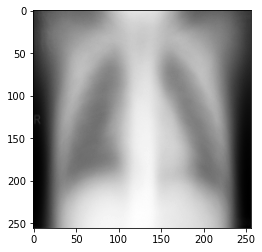

In [61]:
temp_features = features.numpy()
temp_ = temp_features.copy()
temp_features[:,:,:,:] = 0
temp_features[:,:,index,:] = temp_[:,:,index,:]
recon = model.regenerate_image(temp_features)
recon = tf.reshape(recon, (256,256))
plt.imshow(recon, cmap='gray')

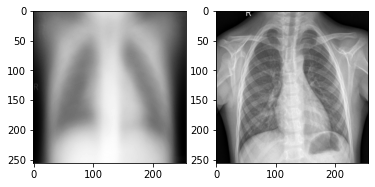

In [62]:
temp_features = features.numpy()
temp_ = temp_features.copy()
temp_features[:,:,:,:] = 0
temp_features[:,:,index,:] = temp_[:,:,index,:]

recon = model.regenerate_image(temp_features)
recon = tf.reshape(recon, (256,256))

plt.subplot(1,2,1)
plt.imshow(recon, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(X_test[index_,:,:,0], cmap='gray')

In [63]:
col = np.zeros((256,2816))
for i in range(8): 
    feature_ = temp_features.copy()
    feature_[:,:,index, i] += -0.25
    row = np.zeros((256,256))
    for j in range(10):
        feature_[:,:,index, i] += 0.05
        row = np.hstack([row, tf.reshape(model.regenerate_image(tf.convert_to_tensor(feature_)), (256,256)).numpy()])
    col = np.vstack([col, row])

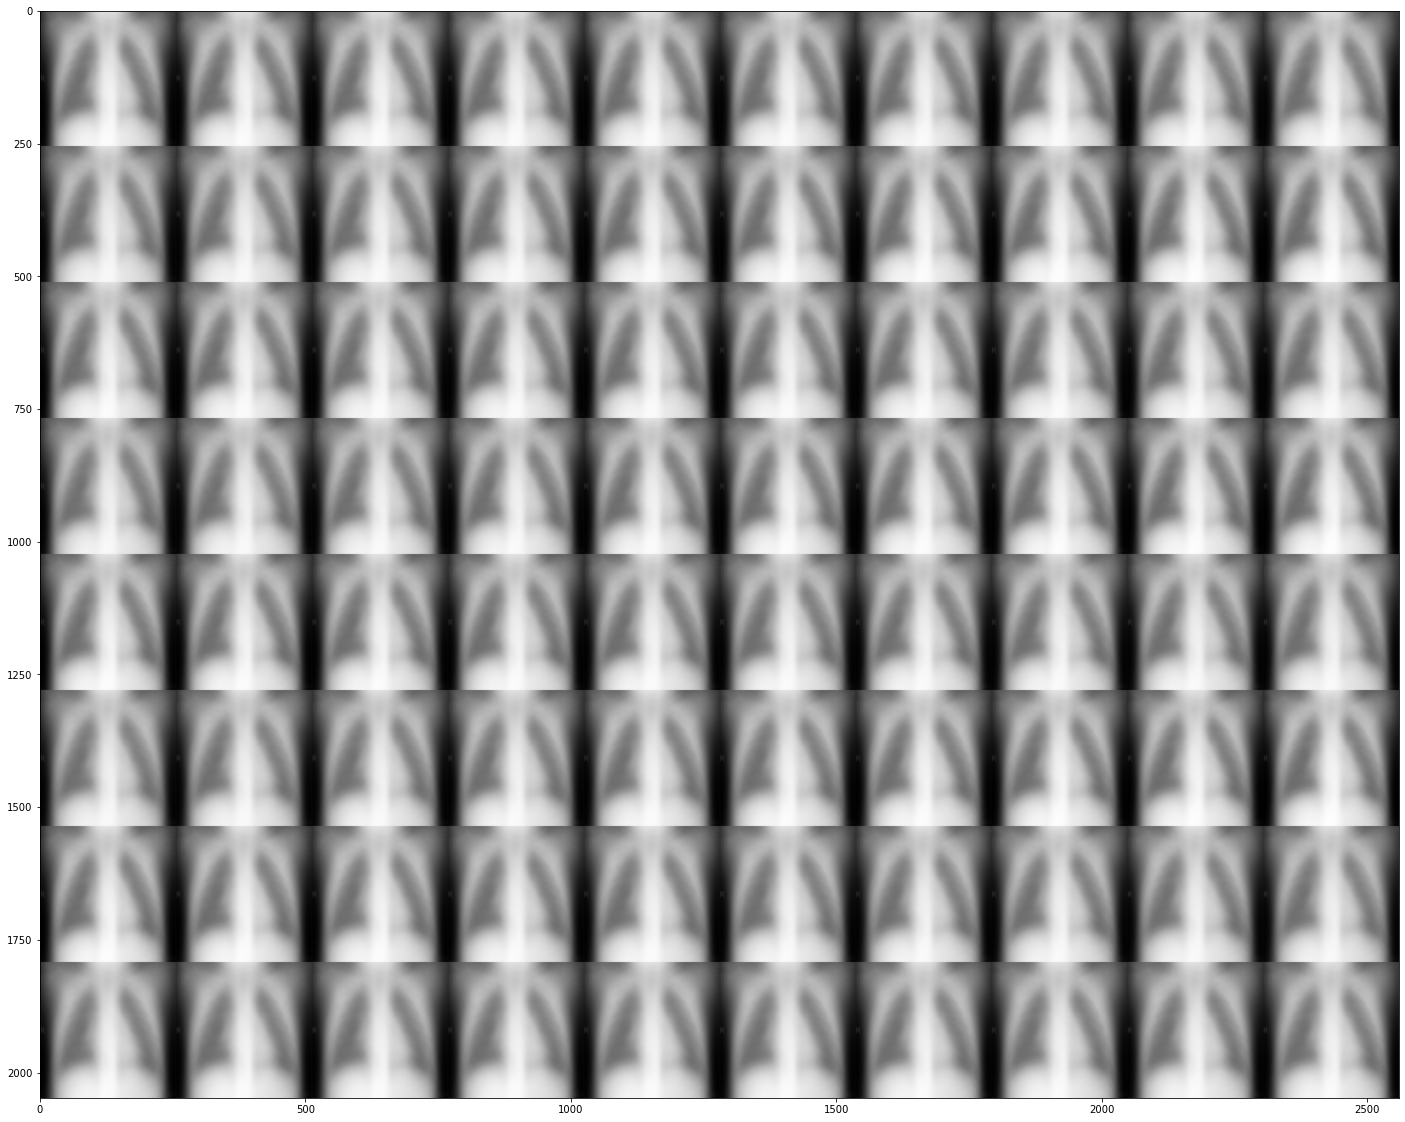

In [64]:
plt.figure(figsize=(30,20))
plt.imshow(col[256:, 256:], cmap='gray')